In [34]:
import numpy as np
import torch
import pandas
import matplotlib.pyplot as plt

In [35]:
class NNet(torch.nn.Module):
    
    def __init__(self, n_inputs, n_hiddens_per_layer, n_outputs, act_func='tanh'):
        super().__init__()  # call parent class (torch.nn.Module) constructor
        
        # Set self.n_hiddens_per_layer to [] if argument is 0, [], or [0]
        if n_hiddens_per_layer == 0 or n_hiddens_per_layer == [] or n_hiddens_per_layer == [0]:
            self.n_hiddens_per_layer = []
        else:
            self.n_hiddens_per_layer = n_hiddens_per_layer

        self.hidden_layers = torch.nn.ModuleList()  # necessary for model.to('cuda')

        for nh in self.n_hiddens_per_layer:
            self.hidden_layers.append( torch.nn.Sequential(
                torch.nn.Linear(n_inputs, nh),
                torch.nn.Tanh() if act_func == 'tanh' else torch.nn.ReLU()))
            
            n_inputs = nh

        self.output_layer = torch.nn.Linear(n_inputs, n_outputs)
            
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None

        self.error_trace = []
        
    def forward(self, X):
        Y = X
        for hidden_layer in self.hidden_layers:
            Y = hidden_layer(Y)
        Y = self.output_layer(Y)
       # print(Y.size)
        return Y

    
    
    
    def train(self, X, T, n_epochs, learning_rate, verbose=True):
        
        error_convert_f = lambda err: (np.sqrt(error1) * self.Tstds)[0]

        # Set data matrices to torch.tensors if not already.
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float()
        if not isinstance(T, torch.Tensor):
            T = torch.from_numpy(T).float()
            
        # Calculate standardization parameters if not already calculated
        if self.Xmeans is None:
            self.Xmeans = X.mean(0)
            self.Xstds = X.std(0)
            self.Xstds[self.Xstds == 0] = 1
            self.Tmeans = T.mean(0)
            self.Tstds = T.std(0)
            self.Tstds[self.Tstds == 0] = 1
            
        # Standardize inputs and targets
        X = (X - self.Xmeans) / self.Xstds
        T = (T - self.Tmeans) / self.Tstds
        
        # Set optimizer to Adam and loss functions to MSELoss
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        mse_func = torch.nn.MSELoss()

        # For each epoch:
        #   Do forward pass to calculate output Y.
        #   Calculate mean squared error loss, mse.
        #   Calculate gradient of mse with respect to all weights by calling mse.backward().
        #   Take weight update step, then zero the gradient values.
        #   Unstandardize the mse error and save in self.error_trace
        #   Print epoch+1 and unstandardized error if verbose is True and
        #             (epoch+1 is n_epochs or epoch+1 % (n_epochs // 10) == 0)
        
        for epoch in range(n_epochs):
            
            
            Y = self(X)
            
            mse= mse_func(T,Y)
            mse.backward()
  
            optimizer.step()
            optimizer.zero_grad()
            error1=mse.detach().numpy()
            error=error_convert_f(error1)
            
            if verbose and (epoch+1==n_epochs or (epoch+1) %(n_epochs//10) == 0):
                print(f'Epoch {epoch+1:d} Error={error:.5f}')
            
            
    def use(self, X):
        
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float()   # Set input matrix to torch.tensors if not already.
            
       
        X = (X - self.Xmeans) / self.Xstds   # Standardize X
            
            
        # Do forward pass and unstandardize resulting output. Assign to variable Y.
        Y = self(X)
        Y =  Y*self.Tstds + self.Tmeans
        # Return output Y after detaching from computation graph and converting to numpy
        
        return Y.detach().numpy()
    
            
    

In [36]:
torch.manual_seed(42)
np.random.seed(42)
    
n_samples = 10000
X = np.linspace(0, 10, n_samples).reshape((-1, 1))
T = X ** 2
n_samples, n_inputs = X.shape 
n_outputs = T.shape[1]
n_hiddens = [100, 100]
net = NNet(n_inputs, n_hiddens, n_outputs, act_func='relu')
net.train(X, T, 50, 0.01)
Y=net.use(X)

def rmse(Y, T):
    return np.sqrt(np.mean((T - Y)**2))

print(f'RMSE {rmse(Y, T):.3f}')




Epoch 5 Error=11.15545
Epoch 10 Error=6.06195
Epoch 15 Error=5.16921
Epoch 20 Error=2.10268
Epoch 25 Error=2.31699
Epoch 30 Error=2.63575
Epoch 35 Error=1.46300
Epoch 40 Error=1.13660
Epoch 45 Error=1.17029
Epoch 50 Error=0.92157
RMSE 0.867


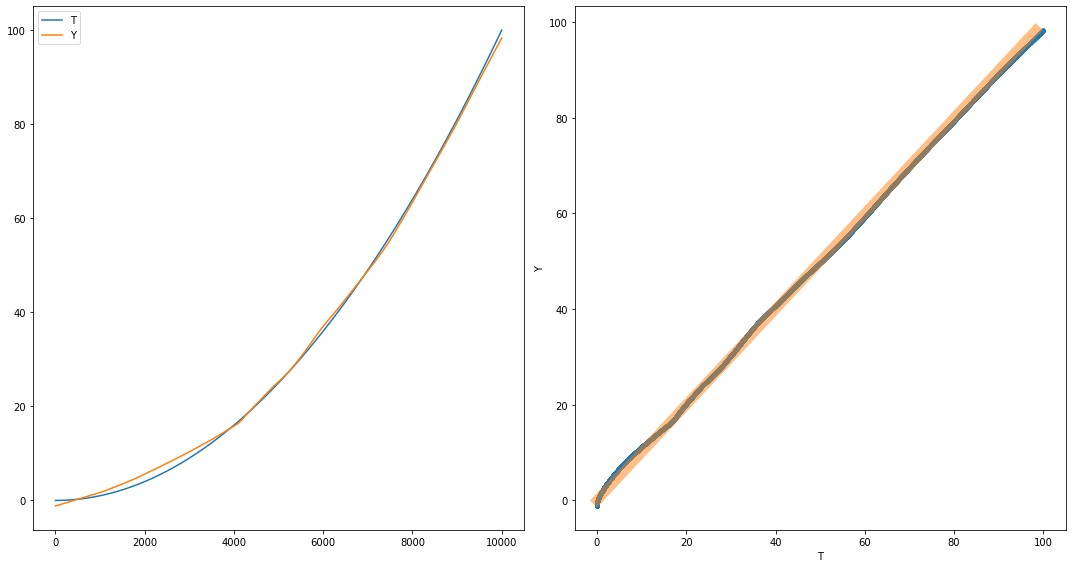

In [37]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.plot(T, label='T')
plt.plot(Y, label='Y')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(T, Y, '.')
a = max(np.min(T), np.min(Y))
b = min(np.max(T), np.max(Y))
plt.plot([a, b], [a, b], lw=10, alpha=0.5)
plt.xlabel('T')
plt.ylabel('Y')
plt.tight_layout()

In [38]:
def generate_k_fold_cross_validation_sets(X, T, n_folds, shuffle=True):

    if shuffle:
        # Randomly order X and T
        randorder = np.arange(X.shape[0])
        np.random.shuffle(randorder)
        X = X[randorder, :]
        T = T[randorder, :]

    # Partition X and T into folds
    n_samples = X.shape[0]
    n_per_fold = round(n_samples / n_folds)
    n_last_fold = n_samples - n_per_fold * (n_folds - 1)

    folds = []
    start = 0
    for foldi in range(n_folds-1):
        folds.append( (X[start:start + n_per_fold, :], T[start:start + n_per_fold, :]) )
        start += n_per_fold
    folds.append( (X[start:, :], T[start:, :]) )

    # Yield k(k-1) assignments of Xtrain, Train, Xvalidate, Tvalidate, Xtest, Ttest

    for validation_i in range(n_folds):
        for test_i in range(n_folds):
            if test_i == validation_i:
                continue

            train_i = np.setdiff1d(range(n_folds), [validation_i, test_i])

            Xvalidate, Tvalidate = folds[validation_i]
            Xtest, Ttest = folds[test_i]
            if len(train_i) > 1:
                Xtrain = np.vstack([folds[i][0] for i in train_i])
                Ttrain = np.vstack([folds[i][1] for i in train_i])
            else:
                Xtrain, Ttrain = folds[train_i[0]]

            yield Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest

In [39]:
X = np.arange(2 * 6).reshape((6, 2))
T = np.arange(6).reshape((6, 1)) * 10
X, T

(array([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11]]), array([[ 0],
        [10],
        [20],
        [30],
        [40],
        [50]]))

In [40]:
np.random.seed(42)

for Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest in generate_k_fold_cross_validation_sets(X, T, 3):
    
    print('Xtrain\n', Xtrain)
    print('Ttrain\n', Ttrain)
    print('Xvalidate\n', Xvalidate)
    print('Tvalidate\n', Tvalidate)
    print('Xtest\n', Xtest)
    print('Ttest\n', Ttest)

Xtrain
 [[8 9]
 [6 7]]
Ttrain
 [[40]
 [30]]
Xvalidate
 [[0 1]
 [2 3]]
Tvalidate
 [[ 0]
 [10]]
Xtest
 [[10 11]
 [ 4  5]]
Ttest
 [[50]
 [20]]
Xtrain
 [[10 11]
 [ 4  5]]
Ttrain
 [[50]
 [20]]
Xvalidate
 [[0 1]
 [2 3]]
Tvalidate
 [[ 0]
 [10]]
Xtest
 [[8 9]
 [6 7]]
Ttest
 [[40]
 [30]]
Xtrain
 [[8 9]
 [6 7]]
Ttrain
 [[40]
 [30]]
Xvalidate
 [[10 11]
 [ 4  5]]
Tvalidate
 [[50]
 [20]]
Xtest
 [[0 1]
 [2 3]]
Ttest
 [[ 0]
 [10]]
Xtrain
 [[0 1]
 [2 3]]
Ttrain
 [[ 0]
 [10]]
Xvalidate
 [[10 11]
 [ 4  5]]
Tvalidate
 [[50]
 [20]]
Xtest
 [[8 9]
 [6 7]]
Ttest
 [[40]
 [30]]
Xtrain
 [[10 11]
 [ 4  5]]
Ttrain
 [[50]
 [20]]
Xvalidate
 [[8 9]
 [6 7]]
Tvalidate
 [[40]
 [30]]
Xtest
 [[0 1]
 [2 3]]
Ttest
 [[ 0]
 [10]]
Xtrain
 [[0 1]
 [2 3]]
Ttrain
 [[ 0]
 [10]]
Xvalidate
 [[8 9]
 [6 7]]
Tvalidate
 [[40]
 [30]]
Xtest
 [[10 11]
 [ 4  5]]
Ttest
 [[50]
 [20]]


In [41]:
def run_k_fold_cross_validation(X, T, n_folds, list_of_n_hiddens, 
                                n_epochs, learning_rate, act_func):
    
    
    
    
    
    
    results_total=[]
    
    for nh in list_of_n_hiddens :
        
        results =[]
        results1=[]
        
       
        
        for Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest in generate_k_fold_cross_validation_sets(X, T, n_folds):
            
                net = NNet(Xtrain.shape[1], nh, Ttrain.shape[1])
                net.train(Xtrain, Ttrain, n_epochs, learning_rate)
                
                results1.append([ 
                                (rmse(Ttrain, net.use(Xtrain))),
                                (rmse(Tvalidate, net.use(Xvalidate))),
                                (rmse(Ttest, net.use(Xtest)))])
         
        #print(results1,type(results1))
        results2 = np.array(results1)
        results1=(np.mean(results2,axis=0))
        results1=results1.tolist()
        #print('mean kkk result ',results1,type(results1),len(results1))
        #results1=(np.mean(results1,axis=0))
        
        results.append(nh)
        results_total.append(results+results1)
       
    results_total = pandas.DataFrame(results_total, columns=('arch', 'RMSE Train','RMSE Val', 'RMSE Test'))
    return results_total   
           
        
        #print('printing yo result lists',results,type(results),len(results))

    #results = pandas.DataFrame(results, columns=('arch', 'RMSE Train','RMSE Val', 'RMSE Test'))


In [42]:
#!curl -O https://archive.ics.uci.edu/ml/machine-learning-databases/00291/
import pandas 
airfoil = pandas.read_csv('airfoil_self_noise.dat', delimiter='\t',
                          names=('frequency', 'angle', 'chord', 
                                 'velocity', 'thickness', 'pressure'))

data = airfoil.dropna()
data = airfoil.iloc[:, :].values
T = data[:,5:]
X = data[:,:5]



In [43]:
torch.manual_seed(42)
np.random.seed(42)

import time
start = time.time()

results = run_k_fold_cross_validation(X, T, 5,
                                      [[],[1],[5],[200, 200]],
                                      200, 0.01, 'tanh')


elapsed = (time.time() - start) / 60/ 60
print(f'Took {elapsed:.2f} hours')
results

Epoch 20 Error=7.08663
Epoch 40 Error=6.10765
Epoch 60 Error=5.54745
Epoch 80 Error=5.20149
Epoch 100 Error=5.01565
Epoch 120 Error=4.92485
Epoch 140 Error=4.88381
Epoch 160 Error=4.86612
Epoch 180 Error=4.85866
Epoch 200 Error=4.85558
Epoch 20 Error=7.67340
Epoch 40 Error=6.21070
Epoch 60 Error=5.39083
Epoch 80 Error=5.03569
Epoch 100 Error=4.91447
Epoch 120 Error=4.88240
Epoch 140 Error=4.87614
Epoch 160 Error=4.87531
Epoch 180 Error=4.87523
Epoch 200 Error=4.87520
Epoch 20 Error=7.47603
Epoch 40 Error=6.27370
Epoch 60 Error=5.51613
Epoch 80 Error=5.10855
Epoch 100 Error=4.91502
Epoch 120 Error=4.83382
Epoch 140 Error=4.80426
Epoch 160 Error=4.79498
Epoch 180 Error=4.79243
Epoch 200 Error=4.79179
Epoch 20 Error=5.08506
Epoch 40 Error=4.81216
Epoch 60 Error=4.78943
Epoch 80 Error=4.77051
Epoch 100 Error=4.76297
Epoch 120 Error=4.75958
Epoch 140 Error=4.75835
Epoch 160 Error=4.75795
Epoch 180 Error=4.75785
Epoch 200 Error=4.75783
Epoch 20 Error=5.74004
Epoch 40 Error=5.01397
Epoch 60 E

,arch,RMSE Train,RMSE Val,RMSE Test
0,[],4.790511,4.839218,4.840742
1,[1],4.519531,4.550374,4.544003
2,[5],3.945287,4.075278,4.056469
3,"[200, 200]",1.247415,1.835053,1.811719


In [44]:
len(results)

4

In [45]:
results 

,arch,RMSE Train,RMSE Val,RMSE Test
0,[],4.790511,4.839218,4.840742
1,[1],4.519531,4.550374,4.544003
2,[5],3.945287,4.075278,4.056469
3,"[200, 200]",1.247415,1.835053,1.811719


In [46]:
def plot_results(results):
    errors = results.iloc[:, 1:].values
    archs = results.iloc[:, 0].values
    archs = [str(ar) for ar in archs]

    plt.plot(archs, errors, 'o-')
    plt.legend(('Train', 'Validate', 'Test'))
    plt.ylabel('RMSE')
    plt.xticks(range(errors.shape[0]), archs, rotation=45, ha='right')
    plt.tight_layout()

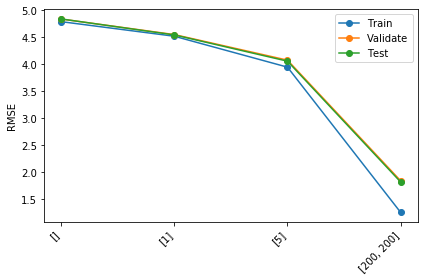

In [47]:
plot_results(results)

# Observations:

1.we have tested on various kinds of architectures in neural network like linear model with no hidden layers,and complex models 
with change in no.of units per hidden layer and no.of hidden layers. 
2.from the results table we can observe that rmse of the network with [200,200] hidden layer architecture is very low compared to the other architectures.Also the complex the neural network the more lesser rmse value. i.e. drop in rmse from top to bottom of table.
3.for the last type of architectures model( [200,200]) is trained well and it is clear a evidence from rmse values of the train is less with respective to the validation and test rmse. for the remaining networks trained data worked well since rmses of validation and tests are similar range to that of trained rmse value.
4.plotting representation is the perfect way of how well the neural network is trained and behaved.most complex network is having less amount of rmse value close to X-axis.
5.this giving an inference that when the model architecture is complex with different kinds of hidden layers and number of neurons per layer the more accurately it is working on the test data.
6.the concept of  nfolds non intersecting partition sets which is finding all kinds of permutations possible ways of dividing entire data into 1 validation ,1 test and remaining data into training makes that all data is somehow exposed to the training, testing and validatiion sets.
7.previously we have divided the data into 80% train and 20% test on random shuffling which reduces the possibilty of training data exposing to test samples. with this partition technique model is trained with all samples of data in any one of the partition sets.
8.From the graph we can also infer that there is a deviation between training and testing,validation sets for the last architecture ensures the possibilty that neural network training data may not be sufficient to train the model.
9.since we are validating with pytorch we can see that it has in built functions which will calculate the gradient with backward(),inbuilt optimisers and how the neural network class objects is used to internally call the forward() . we also inferenced how tensors are attached to the computational graph and how we need to detach them when we want to use for numpy calculations.
10.The computational time for this model is high(0.2hrs), since it is need to train model on different kinds of the data sets also depends on folds we have choosen.If the data size is so high the time may take still large amount of time.may be usage of GPU will then be significant for these kind of methods.



In [48]:
%run -i A3grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'GADDAM -A3.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing
    torch.manual_seed(142)

    X = np.arange(40).reshape(20, 2)
    T = np.log(1 + X[:, 0:1])

    nnet = NNet(X.shape[1], [10, 10], T.shape[1], act_func='relu')
    nnet.train(X, T, 100, 0.01, verbose=False)

    first_Y = nnet.use(X)[0, 0]


--- 30/30 points. Returned correct value.

Testing
    torch.manual_seed(142)

    X = np.arange(40).reshape(20, 2)
    T = np.log(1 + X[:, 0:1])

    nnet = NNet(X.shape[1], [10, 10], T.shape[1], act_func='tanh')  # Using tanh
    nnet.train(X, T, 100, 0.01, verbose=False)

    first_Y = nnet.use(X)[0, 0]


--- 30/30 points. Returned correct value.

Testing
    torch.manual_seed(400)
    np.random.seed(400)

    X = np.arange(40).reshape(20, 2)
    T = np.log(1 + X[:, 0:1])
    
    results = run_k_f